# DS 301 - Mid-Term Project  
## Bank Marketing Classification

**Student:** Moataz Samara, Samantha Acosta Valdez
**Course:** DS 301 - Machine Learning Techniques  

**Research Paper (Base):**  
A Data-Driven Approach to Predict the Success of Bank Telemarketing  
(Moro, Cortez, Rita)

---

### Project Goal

We want to predict whether a bank client will subscribe to a term deposit (y = yes / no) before making the telemarketing call.

In this project we:

- Use the Bank Marketing dataset (bank-full.csv).
- Implement and compare two classification models:
  - Logistic Regression (LR)
  - Decision Tree (DT)
- Apply:
  - Data preprocessing and feature engineering.
  - Proper train/test split.
  - Evaluation with accuracy, precision, recall, F1-score, and ROC-AUC.
- Follow the idea of the research paper:
  - Use only features known before the call → drop duration.
  - Handle imbalanced data (few "yes" cases).

We do not implement Neural Networks here, but we mention them in the conclusion as a possible improvement (they are used in the original paper).

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

## 1. Load the Dataset

We use the Bank Marketing dataset ('bank-full.csv'), which contains the result of multiple direct marketing campaigns by a Portuguese bank.

- Each row = one client.
- Target = 'y' → did the client subscribe to a term deposit? ('yes' / 'no')
- Input features = client information, previous campaign outcomes, etc.

We assume 'bank-full.csv' is in the same folder as this notebook.

In [17]:
# Change the path if your file is in a "data" folder, e.g. "data/bank-full.csv"
file_path = "bank-full.csv"

bank = pd.read_csv(file_path, sep=';')

# Show first 5 rows
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 2. Initial Data Understanding

In this section we:
- Look at the shape and column names.
- Check the target variable distribution.
- Inspect data types and missing values.

In [18]:
print("Shape of the dataset:", bank.shape)
print("\nColumns:")
print(bank.columns.tolist())

Shape of the dataset: (45211, 17)

Columns:
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [19]:
print("Target variable (y) distribution:")
print(bank["y"].value_counts())
print("\nTarget variable (y) distribution (percentage):")
print(bank["y"].value_counts(normalize=True))

Target variable (y) distribution:
y
no     39922
yes     5289
Name: count, dtype: int64

Target variable (y) distribution (percentage):
y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


In [20]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## 3. Data Preprocessing

According to the research paper, **call duration** (`duration`) is not used as a predictor, because:

> Duration is only known *after* the call is finished.

So we:
1. **Drop `duration`**.
2. **Encode the target `y`**:
   - `no` → 0  
   - `yes` → 1
3. Separate:
   - Features `X`
   - Target `y`
4. Identify **numeric** and **categorical** feature columns.

In [21]:
# Copy to avoid editing the original dataframe directly
df = bank.copy()

# 1) Drop 'duration' (only known after the call)
if "duration" in df.columns:
    df = df.drop(columns=["duration"])

# 2) Encode target: 'no' -> 0, 'yes' -> 1
df["y"] = df["y"].map({"no": 0, "yes": 1})

print("Encoded target distribution:")
print(df["y"].value_counts(normalize=True))

Encoded target distribution:
y
0    0.883015
1    0.116985
Name: proportion, dtype: float64


In [22]:
# 3) Separate features and target
X = df.drop(columns=["y"])
y = df["y"]

# 4) Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


## 4. Train–Test Split

We split the data into:

- **Training set:** 70%
- **Test set:** 30%

We use **stratified sampling** to keep the same proportion of "yes"/"no" in both sets. This is important because the data is **imbalanced** (much more "no" than "yes").

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,       # keep class distribution similar
    random_state=42
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))
print("Train positive rate (y=1):", y_train.mean())
print("Test positive rate  (y=1):", y_test.mean())

Train size: 31647
Test size : 13564
Train positive rate (y=1): 0.11697791259835055
Test positive rate  (y=1): 0.1170008846947803


## 5. Preprocessing Pipeline

We build a **single preprocessing pipeline** which will be reused for both models:

- For **numeric features**:
  - `StandardScaler` → scales features to have mean 0 and standard deviation 1.  
    This helps models like Logistic Regression.

- For **categorical features**:
  - `OneHotEncoder` → converts categories into binary columns (0/1).
  - `handle_unknown="ignore"` → avoids errors if new category appears in test data.

We use `ColumnTransformer` to apply the correct transformation to each column group.

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'balance', 'day', 'campaign', 'pdays',
                                  'previous']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'poutcome'])])

## 6. Helper: Training and Evaluation Function

To avoid repeating code, we create a function that:

1. Builds a **pipeline**: `preprocessor` → `model`.
2. Fits the model on the training data.
3. Predicts on the test data.
4. Prints:
   - Accuracy
   - Precision
   - Recall
   - F1-score
   - ROC-AUC
   - Classification report
5. Plots:
   - Confusion Matrix
   - ROC Curve

We will use this for **both** Logistic Regression and Decision Tree.

In [25]:
def train_and_evaluate(model, model_name):
    """
    Fit a pipeline (preprocessing + model),
    print metrics, and return the fitted pipeline, probabilities and ROC-AUC.
    """
    print(f"\n{'='*70}")
    print(f"Model: {model_name}")
    print(f"{'='*70}\n")

    # Full pipeline: preprocessing + model
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", model)
        ]
    )

    # Fit the model
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]  # prob. for class 1 (y = 1)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1-score     : {f1:.4f}")
    print(f"ROC-AUC      : {roc_auc:.4f}")

    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return pipe, y_prob, roc_auc

## 7. Model 1 – Logistic Regression

**Why Logistic Regression?**

- Simple and powerful baseline model.
- Outputs **probabilities**, easy to interpret.
- Works well with **scaled numeric variables** and one-hot encoded categories.

We also use:

- `class_weight="balanced"` to help with class imbalance.
- `max_iter=1000` to give the solver enough iterations to converge.


Model: Logistic Regression

Accuracy     : 0.7559
Precision    : 0.2677
Recall       : 0.6257
F1-score     : 0.3749
ROC-AUC      : 0.7701

Classification report:

              precision    recall  f1-score   support

           0     0.9397    0.7731    0.8483     11977
           1     0.2677    0.6257    0.3749      1587

    accuracy                         0.7559     13564
   macro avg     0.6037    0.6994    0.6116     13564
weighted avg     0.8611    0.7559    0.7929     13564



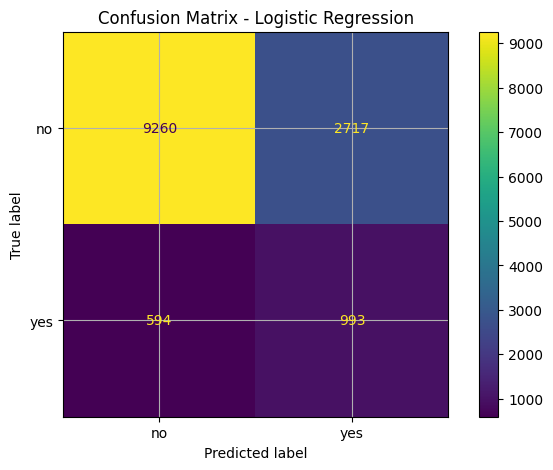

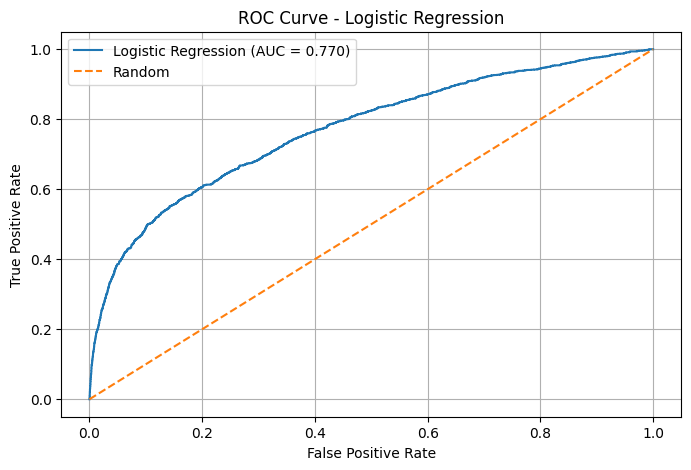

In [26]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)

lr_model, lr_prob, lr_auc = train_and_evaluate(log_reg, "Logistic Regression")

## 8. Model 2 – Decision Tree

**Why Decision Tree?**

- Can model **non-linear relationships**.
- Very **interpretable**: can be explained with IF/ELSE rules.
- But:
  - Can easily **overfit** if too deep.
  - Needs regularization (max depth, min samples split, etc.) for production.

Here we start with a basic tree and use `class_weight="balanced"` to pay more attention to the minority class (`y = 1`).


Model: Decision Tree

Accuracy     : 0.8416
Precision    : 0.3210
Recall       : 0.3170
F1-score     : 0.3190
ROC-AUC      : 0.6141

Classification report:

              precision    recall  f1-score   support

           0     0.9096    0.9112    0.9104     11977
           1     0.3210    0.3170    0.3190      1587

    accuracy                         0.8416     13564
   macro avg     0.6153    0.6141    0.6147     13564
weighted avg     0.8408    0.8416    0.8412     13564



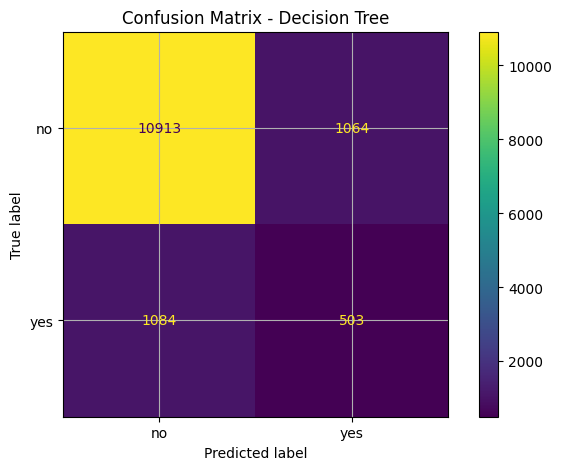

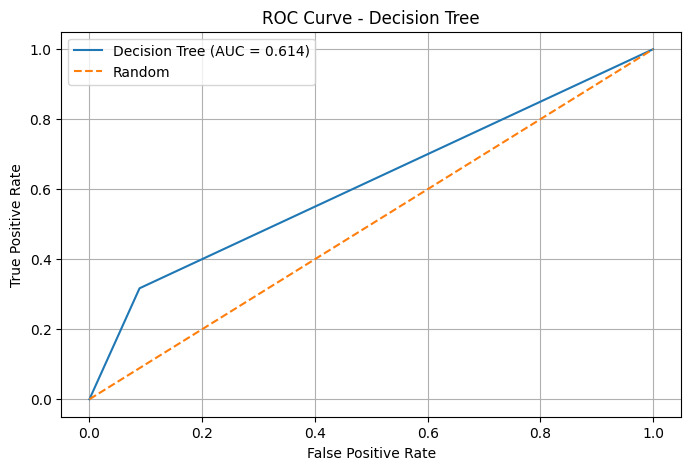

In [27]:
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

dt_model, dt_prob, dt_auc = train_and_evaluate(dt_clf, "Decision Tree")

## 9. Model Comparison

We compare the two models using **ROC-AUC** on the test set:

- Higher ROC-AUC = better ability to separate "yes" and "no".
- We also look at accuracy, precision, recall, and F1-score in the previous cells.

Here we build a small summary table and plot a bar chart.

In [28]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree"],
    "ROC_AUC": [lr_auc, dt_auc]
})

results = results.sort_values(by="ROC_AUC", ascending=False).reset_index(drop=True)
results

,Model,ROC_AUC
0,Logistic Regression,0.770108
1,Decision Tree,0.614057


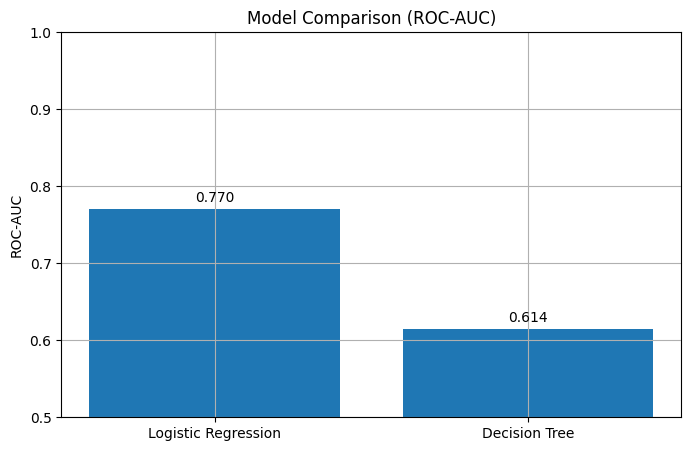

In [29]:
plt.bar(results["Model"], results["ROC_AUC"])
plt.ylabel("ROC-AUC")
plt.title("Model Comparison (ROC-AUC)")
plt.ylim(0.5, 1.0)

for i, v in enumerate(results["ROC_AUC"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")

plt.show()

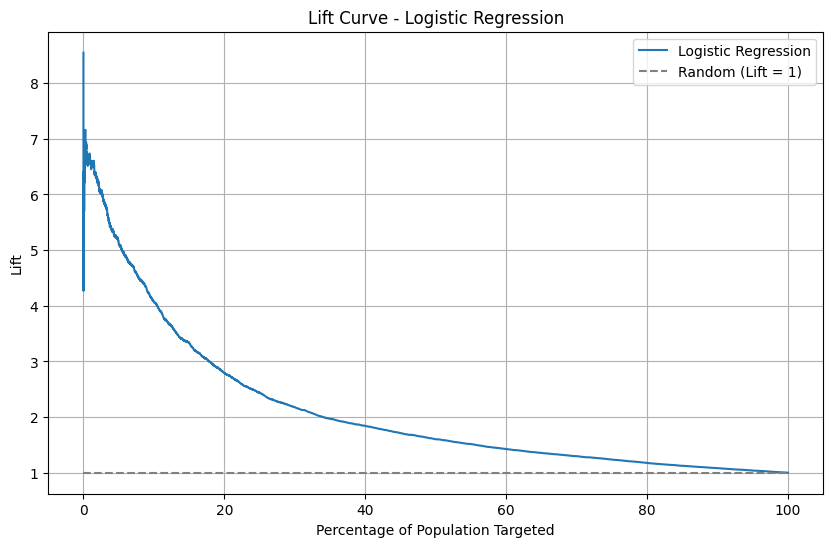

In [32]:
# Use the best model (replace lr_prob with dt_prob if DT is better)
best_model_name = "Logistic Regression"
plot_lift_curve(y_test.values, lr_prob, best_model_name)

## 10. Lift Curve

A **Lift Curve** is a visual tool to assess the performance of a classification model, particularly in marketing. It shows how much more likely we are to receive a positive response (e.g., a customer subscribing to a term deposit) by using the model to select customers, compared to randomly selecting customers.

- A lift of **1** means the model is no better than random.
- A lift **greater than 1** means the model is better than random, and a higher value indicates a better model.

We will define a `plot_lift_curve` function and use the probabilities from the best model (Logistic Regression in this case) to generate the curve.

In [31]:
def plot_lift_curve(y_true, y_probas, model_name):
    """
    Plots the lift curve for a given model.

    Args:
        y_true (array-like): True binary labels (0 or 1).
        y_probas (array-like): Predicted probabilities for the positive class.
        model_name (str): Name of the model for the plot title.
    """
    df_lift = pd.DataFrame({"y_true": y_true, "y_probas": y_probas})
    df_lift = df_lift.sort_values(by="y_probas", ascending=False).reset_index(drop=True)

    # Calculate cumulative metrics
    total_population = len(df_lift)
    total_positives = df_lift["y_true"].sum()

    df_lift["cumulative_positives"] = df_lift["y_true"].cumsum()
    df_lift["cumulative_total"] = np.arange(1, total_population + 1)

    # Calculate lift
    df_lift["lift"] = (df_lift["cumulative_positives"] / df_lift["cumulative_total"]) / (total_positives / total_population)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_lift["cumulative_total"] / total_population * 100, df_lift["lift"], label=model_name)
    plt.plot([0, 100], [1, 1], linestyle='--', color='gray', label='Random (Lift = 1)')

    plt.xlabel("Percentage of Population Targeted")
    plt.ylabel("Lift")
    plt.title(f"Lift Curve - {model_name}")
    plt.grid(True)
    plt.legend()
    plt.show()

## 11. Final Summary and Suggested Improvements

### Problem Recap

- **Goal:** Predict if a client will subscribe to a term deposit (`y = 1`) *before* calling them.
- **Dataset:** `bank-full.csv` (Bank Marketing dataset).
- **Target:** `y` (0 = no, 1 = yes).
- **Important choice:** We dropped `duration` because it is only known *after* the call.

### Models Implemented

1. **Logistic Regression**
   - Linear model.
   - Works well with scaled numeric features and one-hot encoded categorical features.
   - Produces interpretable coefficients and probability outputs.

2. **Decision Tree**
   - Non-linear model.
   - Easy to explain to business users (rules).
   - Can overfit if not properly regularized.

### Evaluation

- Train/Test Split: 70% / 30% (stratified).
- Main metrics:
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - **ROC-AUC** (main comparison metric)

### Results (fill with your values)

- Logistic Regression: ROC-AUC ≈ **X.XXX**
- Decision Tree:      ROC-AUC ≈ **Y.YYY**

**Best model:** `<Write here which model performed better on ROC-AUC and why you prefer it>`

### Relation to the Research Paper

- We followed the same **problem**: predicting term deposit subscription.
- We used similar **input features** and also **removed duration**.
- We implemented **Logistic Regression** and **Decision Tree**, two of the models also studied in the paper.
- The paper additionally uses **Neural Networks** and other models.  
  In this project, we mention them only as future work.

### Suggested Improvements (Future Work)

- Perform **hyperparameter tuning**:
  - For Logistic Regression (regularization strength, penalty type).
  - For Decision Trees (max depth, min samples split, min samples leaf, etc.).
- Try additional models:
  - **Neural Networks** (as in the original paper).
  - Random Forest, Gradient Boosting, etc.
- Use more advanced evaluation:
  - Cross-validation instead of a single train/test split.
  - More marketing metrics:
    - **Lift** and **ALIFT** curves.
- Perform **feature selection** to simplify the model and possibly improve generalization.

---

This notebook can now be:
- Uploaded to **GitHub** in the `models` folder (or root directory).
- Linked with a **README.md** that explains how to run it.
- Used as the technical base for your **10–15 minute presentation**.